In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import beta

In [2]:
theta_1 = 0.3
theta_2 = 0.5
n = 50 # Observations n1, n2
n_chain = 50000 # Markov chain's length
sd = 0.02 # Proposal distribution's standard deviation

In [3]:
z1 = np.random.binomial(n, theta_1)
z2 = np.random.binomial(n, theta_2)

In [4]:
trajectory_1 = [0.01]
trajectory_2 = [0.01]
while len(trajectory_1) < n_chain:
    new_1 = -1
    new_2 = -1
    while new_1 < 0 or new_1 > 1 or new_2 < 0 or new_2 > 1:
        new_1, new_2 = np.random.multivariate_normal([0,0], [[sd, 0], [0, sd]])
    posterior_1 = beta.pdf(new_1, 1 + z1, 1 + n - z1)
    posterior_2 = beta.pdf(new_2, 1 + z2, 1 + n - z2)
    posterior_prev_1 = beta.pdf(trajectory_1[-1], 1 + z1, 1 + n - z1)
    posterior_prev_2 = beta.pdf(trajectory_2[-1], 1 + z2, 1 + n - z2)
    
    p_move = min((posterior_1 * posterior_2) / (posterior_prev_1 * posterior_prev_2), 1)
    
    if np.random.rand(1)[0] < p_move:
        trajectory_1.append(new_1)
        trajectory_2.append(new_2)
    else:
        trajectory_1.append(trajectory_1[-1])
        trajectory_2.append(trajectory_2[-1])

In [8]:
z = [z1, z2]

In [9]:
trajectories = [[0.01], [0.01]]
param = 0
while len(trajectories[0]) < n_chain or len(trajectories[1]) < n_chain:
    new = -1
    while new < 0 or new > 1:
        new = trajectories[param][-1] + np.random.normal(0, sd)
    posterior = beta.pdf(new, z[param] + 1, n - z[param] + 1)
    posterior_prev = beta.pdf(trajectories[param][-1], z[param] + 1, n - z[param] + 1)
    
    p_move = min(posterior / posterior_prev, 1)
    
    if np.random.rand(1)[0] < p_move:
        trajectories[param].append(new)
    else:
        trajectories[param].append(trajectories[param][-1])
        
    param = (param + 1) % 2 

Gibbs gives a much better estimation of the posterior, and it is quicker to run as well. 

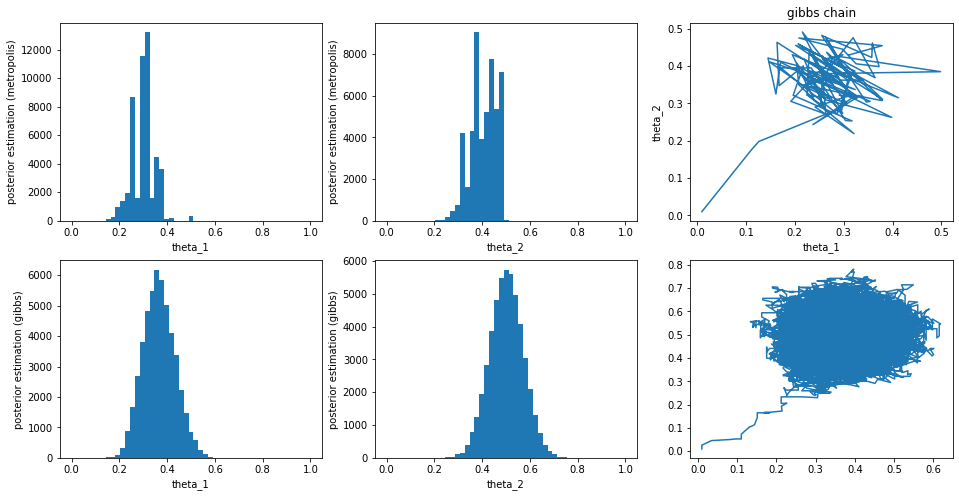

In [13]:
fig, ax = plt.subplots(2, 3)
ax[0, 0].hist(trajectory_1, bins = np.linspace(0, 1, 50))
ax[0, 0].set_xlabel('theta_1')
ax[0, 0].set_ylabel('posterior estimation (metropolis)')
ax[0, 1].hist(trajectory_2, bins = np.linspace(0, 1, 50))
ax[0, 1].set_xlabel('theta_2')
ax[0, 1].set_ylabel('posterior estimation (metropolis)')
ax[0, 2].plot(trajectory_1, trajectory_2)
ax[0, 2].set_xlabel('theta_1')
ax[0, 2].set_ylabel('theta_2')
ax[0, 2].set_title('metropolis chain')
ax[1, 0].hist(trajectories[0], bins = np.linspace(0, 1, 50))
ax[1, 0].set_xlabel('theta_1')
ax[1, 0].set_ylabel('posterior estimation (gibbs)')
ax[1, 1].hist(trajectories[1], bins = np.linspace(0, 1, 50))
ax[1, 1].set_xlabel('theta_2')
ax[1, 1].set_ylabel('posterior estimation (gibbs)')
ax[1, 2].plot(trajectories[0], trajectories[1])
ax[0, 2].set_xlabel('theta_1')
ax[0, 2].set_ylabel('theta_2')
ax[0, 2].set_title('gibbs chain')
fig.set_figwidth(16)
fig.set_figheight(8)